# Casus D: Molecular Dynamics

In [4]:
# imports
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align
from MDAnalysis.analysis.dssp import DSSP, translate
import matplotlib.pyplot as plt

# Tyrosine Kinase YES1

Voor deze opdracht hebben we gekozen voor het [tyrosine-protein kinase Yes eiwit](https://www.uniprot.org/uniprotkb/P07947/). Dit is een niet-receptor tyrosine kinase en behoort tot de Src-familie van kinases (SFK’s). Het eiwit wordt gecodeerd door het YES1-gen, dat vaak hoger tot expressie komt in tumoren, waaronder die in de long, borst, ovarium en huid, zie afbeelding hieronder van [Zhou et al., 2023](https://onlinelibrary.wiley.com/doi/full/10.1002/cai2.51):

![](imgs/yes1_overexpression.jpg)


YES1 speelt een belangrijke rol bij het bevorderen van celproliferatie, celoverleving en de invasiviteit van cellen. Overexpressie van YES1 kan leiden tot resistentie tegen de standaardbehandeling van tyrosinekinase-gedreven kanker, namelijk tyrosinekinase inhibitors (TKI), maar ook tegen chemotherapeutische behandelingen ([Kook et al., 2024](https://doi.org/10.3390/ijms25031450)).

De variant die wij hebben gekozen bestaat uit een deletie die een frameshift veroorzaakt, wat leidt tot een aminozuurverandering van proline (P) naar asparagine (N) op positie 256 in het eiwit. Deze mutatie is geclassificeerd als 'high impact' volgens [The Cancer Genome Atlas Program](https://www.cancer.gov/ccg/research/genome-sequencing/tcga). Deze variant is geassocieerd met adenoom en adenocarcinoom. Voor meer details over de mutatie, zie de afbeelding hieronder. Deze is ook te vinden in de [variant viewer van UniProt](https://www.uniprot.org/uniprotkb/P07947/variant-viewer).

![](imgs/YES1_mutation_variant.png)


Het YES1 eiwit bevat 2 ATP-binding sites, op locatie 283-291 en op locatie 305. Ook bevat het een 'active site' (proton acceptor) op locatie 396 ([UniProt, z.d.](https://www.uniprot.org/uniprotkb/P07947/entry)).

Waar het gen tot expressie komt en waar het voorkomt, verschilt aan de hand van de leeftijd. Bij foetussen komt het tot expressie in de maag, hematopoetische cellen in het beenmerg en de milt. Bij volwassenen komt het eiwit voor in keratinocyten in de basale epiderme laag van de epidermis. Gedurende het hele leven komt het gen tot expressie in de epitheelcellen van de renale proximale tubuli ([UniProt, z.d.](https://www.uniprot.org/uniprotkb/P07947/entry)).

De sequentie van het wildtype is hieronder te zien en kan [hier](https://www.uniprot.org/uniprotkb/P07947/entry#sequences) gedownload worden. Er zijn blokhaken geplaatst om de proline die gemuteerd is bij de mutant variant naar asparagine.

```
>sp|P07947|YES_HUMAN Tyrosine-protein kinase Yes OS=Homo sapiens OX=9606 GN=YES1 PE=1 SV=3
MGCIKSKENKSPAIKYRPENTPEPVSTSVSHYGAEPTTVSPCPSSSAKGTAVNFSSLSMT
PFGGSSGVTPFGGASSSFSVVPSSYPAGLTGGVTIFVALYDYEARTTEDLSFKKGERFQI
INNTEGDWWEARSIATGKNGYIPSNYVAPADSIQAEEWYFGKMGRKDAERLLLNPGNQRG
IFLVRESETTKGAYSLSIRDWDEIRGDNVKHYKIRKLDNGGYYITTRAQFDTLQKLVKHY
TEHADGLCHKLTTVC[P]TVKPQTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTT
KVAIKTLKPGTMMPEAFLQEAQIMKKLRHDKLVPLYAVVSEEPIYIVTEFMSKGSLLDFL
KEGDGKYLKLPQLVDMAAQIADGMAYIERMNYIHRDLRAANILVGENLVCKIADFGLARL
IEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILQTELVTKGRVPYPGMVNRE
VLEQVERGYRMPCPQGCPESLHELMNLCWKKDPDERPTFEYIQSFLEDYFTATEPQYQPG
ENL
```

De sequenties van wildtype/mutant hebben wij gepreprocessed en daarna geupload in AlphaFold, om de structuur van het eiwit te voorspellen.

AlphaFold geeft vijf verschillende voorspellingen van de eiwitstructuur op basis van de sequentie. Om te kijken of deze voorspellingen met elkaar overeenkomen, visualizeren we ze met PyMol. Eerst laden we alle vijf voorspellingen in, om ze vervolgens te alignen. Hiervoor gebruiken we `alignto`, zodat alle voorspellingen in één keer worden aligned.


```python
# align alle voorspellingen aan voorspelling 0
alignto fold_2025_12_12_14_04_mutand_model_0
```

```python
# align alle voorspellingen aan voorspelling 0
alignto fold_2025_12_12_14_04_wildtype_model_0
```

We doen dit voor zowel het wildtype, als het gemuteerde variant. Vervolgens kleuren we de voorspellingen gebaseerd op de 'predicted local distance difference test' (pLDDT):

```python
spectrum b, red_yellow_green_cyan_blue, minimum=50, maximum=90
```

De pLDDT is een lokale maat voor de ‘betrouwbaarheid’ (of 'confidence') van alle regio’s binnen het voorspelde eiwit. Deze score geeft weer hoe zeker het programma is dat de voorspelde vorm correct is. De schaal loopt van 0 tot 100, waarbij 100 staat voor een zeer hoge betrouwbaarheid (en dus een nauwkeurigere voorspelling) en 0 voor een zeer lage betrouwbaarheid (en een minder nauwkeurige voorspelling) ([Embl-Ebi, z.d.](https://www.ebi.ac.uk/training/online/courses/alphafold/inputs-and-outputs/evaluating-alphafolds-predicted-structures-using-confidence-scores/plddt-understanding-local-confidence/)).


Hieronder is het wildtype van YES1 te zien, met daarin duidelijk aangegeven secundaire structuren, met alfa helices (lichtblauw), beta-sheets (paars) en loops (roze).

<video width="320" height="240" controls>
  <source src="imgs/secondary_structures.mp4" type="video/mp4">
</video>

## Wildtype
Eerst bekijken we de 5 voorspellingen van het wildtype. Het is gelijk duidelijk dat de voorspellingen sterk overeenkomen, vooral in het centrale gedeelte, hier liggen een aantal alpha-helices en beta-sheets, waarvan de locatie slechts lichtelijk verschilt tussen de voorspellingen. Dit gedeelte heeft dan ook een hoog pLDDT, dit is te zien aan de donkerblauwe kleur. Alle stukken met deze kleur hebben een pLDDT van > 90. De stukken waar weinig zekerheid lijkt te zijn bij de voorspellingen zijn de dunne 'slierten' om het eiwit heen. De kleur hier is rood, dat betekent een pLDDT van ~50 of lager. Deze stukken verschillen dan ook sterk onderling tussen de voorspellingen. Vandaar ook de 'sliert' vorm, omdat AlphaFold niet heeft kunnen bepalen hoe deze stukken er ruimtelijk uitzien. Opvallend is, dat de pLDDT lijkt te variëren van erg zeker tot erg onzeker, maar dat er weinig stukken zijn die hier tussen in vallen. Dit zijn dan vaak hele korte stukken, opvallend leek bijvoorbeeld de regio in de derde afbeelding. Hier was wel een duidelijke alfa-helix te zien, maar deze leek te verschillen tussen de voorspellingen.

![](imgs/wildtype_1.png)

![](imgs/wildtype_2.png)

![](imgs/wildtype_3.png)

## Mutant
Nu bekijken we de 5 voorspellingen van de gemuteerde variant. Over het algemeen lijkt de eiwitstructuur nog grotendeels hetzelfde als dat van het wildtype. Waarschijnlijk omdat de enkele mutatie niet genoeg is om de complete eiwitstructuur aan te tasten. Ook hier weer heeft het centrale deel een hoge pLDDT en zijn er slierten om het eiwit heen met een lage pLDDT. Opvallend is dat het gebied uit de derde afbeelding van wildtype 3 er anders uitziet bij het wildtype, hier lijken 2 kleine alfa-helices te vormen (wel met lage pLDDT). De mutatie zelf zit op plek 256 en is niet in de buurt van deze verandering. Dus toch zorgt de enkele mutatie voor structurele veranderingen verderop in het eiwit. Dit kan natuurlijk worden verklaard door de frameshift.

![](imgs/mutant_1.png)

![](imgs/mutant_2.png)

![](imgs/mutant_3.png)

Als we dan nu de eerste voorspelling van zowel het wildtype als de mutant vergelijken dan krijgen we het resultaat hieronder:

![](imgs/mutant_vs_wildtype.png)

De aminozuren om de mutatie heen zijn nog hetzelfde, alleen lijken ze niet heel netjes gealigned, dus de structuur lijkt iets veranderd. De mutatie zelf, van proline naar asparagine valt erg op omdat de structuren van deze aminozuren erg anders zijn. Zie de structuren hieronder, met links proline en rechts asparagine. In de pymol afbeelding is de ring van proline goed te zien en ook de zijketen van asparagine. Gezien de structuren zo anders zijn kunnen wij ons goed voorstellen dat deze mutatie grote gevolgen kan hebben. Op basis van structuur alleen is het echter lastig om hier verdere uitspraken over te doen, en zullen wij ook gaan kijken naar de beweging van het eiwit.

![](imgs/proline.png)
![](imgs/asparagine.png)




# Visualisatie van wildtype en mutant

In het weekend zijn de simulaties van de beweging van het aangedane eiwit en het wildtype variant gemaakt met behulp van [Gromacs](https://www.gromacs.org/). Per variant zijn er veel bestanden gegenereerd, waaronder logbestanden. Deze zullen wij eerst inspecteren om wat beter te begrijpen wat Gromacs allemaal heeft uitgevoerd om tot de simulatie van 100ms te komen. In totaal bestaat het uit 9 verschillende stappen.

Het bekijken van de simulatie in PyMol:
- Om het eiwit heen zijn veel watermoleculen gesimuleerd, dit komt doordat er een grote lus vastzit aan het eiwit, dat zich ver uit kan strekken. Om deze reden is het kader van de simulatie van het water best groot geworden en zijn er veel watermoleculen in mee genomen. In ons geval zijn wij alleen geinteresseerd in de beweging van het eiwit en in de verschillen tussen wildtype en mutatie. Gezien wij niet specifiek geïnteresseerd zijn in de interactie met water, kunnen wij dit weg laten bij het bekijken in PyMol, wat het gelijk ook een stuk aangenamer maakt om te bekijken.

Om Gromacs te kunnen gebruiken, moeten we eerst de source instellen met:

```
source /usr/local/gromacs-2024.5/bin/GMXRC
```

Vervolgens kunnen we het command `trjconv` runnen, met dit command kunnen 'trajectory files' zoals .xtc worden aangepast op verschillende manieren. Bijvoorbeeld het maken van een subset van de atomen, in ons geval het maken van een subset die alleen de atomen van het eiwit zelf bevat en niet van overige atomen zoals die in o.a. de watermoleculen voorkomen. Als input gebruiken we het .xtc en .tpr bestand dat in het weekend is gegenereerd. Hiervoor kunnen we *MD.tpr en *MD.xtc gebruiken, omdat er in een folder van een run slechts één van elk van deze bestanden zit. (Met -pbc mol wordt de 'periodic boundary condition' aangepast op een manier dat) -> navragen wat de setting -pbc mol precies doet

```
gmx trjconv -s *MD.tpr -f *MD.xtc -pbc mol -o protein_.xtc
```

Na het runnen van dit command, komt er een menu te staan waar wordt gevraagd om wat voor soort subset er gemaakt moet worden, met een lijst van de verschillende soorten subsets, zie hieronder. Het is gelijk duidelijk dat een groot gedeelte van de deeltjes bestaat uit water, in het geval van de mutant is dit 300492/309552 van het totaal, dus slechts 9060 deeltjes geen water zijn, dit zijn atomen uit het eiwit en ionen. Zoals net is uitgelegd hebben we geen water nodig en ook hebben we de overige ionen niet nodig, dus kiezen we groep 1, waarbij alleen het eiwit zelf behouden blijft.

```
Select group for output
Group     0 (         System) has 309552 elements
Group     1 (        Protein) has  8502 elements
Group     2 (      Protein-H) has  4281 elements
Group     3 (        C-alpha) has   543 elements
Group     4 (       Backbone) has  1629 elements
Group     5 (      MainChain) has  2173 elements
Group     6 (   MainChain+Cb) has  2671 elements
Group     7 (    MainChain+H) has  2686 elements
Group     8 (      SideChain) has  5816 elements
Group     9 (    SideChain-H) has  2108 elements
Group    10 (    Prot-Masses) has  8502 elements
Group    11 (    non-Protein) has 301050 elements
Group    12 (          Water) has 300492 elements
Group    13 (            SOL) has 300492 elements
Group    14 (      non-Water) has  9060 elements
Group    15 (            Ion) has   558 elements
Group    16 ( Water_and_ions) has 301050 elements
```

Vervolgens hebben we ook een pdb nodig die is aangepast op het feit dat we alle andere moleculen buiten het eiwit niet willen bekijken in PyMol. Dit doen we door de eerste frame te 'dumpen':

```
gmx trjconv -s fold_2025_12_12_14_04_mutand_model_0-MD.tpr -f fold_2025_12_12_14_04_mutand_model_0-MD.xtc -pbc mol -o ../mutand/mutant_protein.pdb -dump 0
```


## De stappen van Gromacs
### Stap 1: generate structure and topology
Deze stap wordt besproken in het `01-PDB2GMX.log` log bestand. In deze stap wordt bepaald over welke (combinaties van) atomen de krachten moeten worden uitgeoefend (https://manual.gromacs.org/documentation/current/reference-manual/topologies/topologies.html). Hierbij wordt (in ons geval) het `Amber99sb-ildn` force-field en het `tip3p` water model gebruikt.

Het Amber99sb-ildn force-field is specifiek ontworpen om met eiwitten te werken (https://ambermd.org/AmberModels_proteins.php).

#### tip3p (Transferable Intermolecular Potential 3 Points)

Het tip3p water model werkt met 3 verschillende interactiepunten, één voor elk atoom binnen het molecuul.

Elk punt hierbij heeft een eigen lading en het zuurstofatoom heeft ook Lennard-Jones parameters. https://en.wikipedia.org/wiki/Water_model#3-site

Lennard-Jones parameters geven aan
https://pubs.acs.org/doi/10.1021/acs.jpcb.5c05129

Ook wordt er in deze stap gekeken naar 'occupancies', dit is hoe de configuratie van verschillende elementen wordt bekeken. Gezien er wordt gewerkt met 3D-structuren betekent dit dat deze op verschillende manieren georienteerd kunnen zijn. Gromacs kijkt naar de occupancies in het input pdb bestand en checkt of alle occupancies van alle elementen gelijk is aan 1, wat indiceert dat alle atomen goed binnen de structuren gelegen zijn ([Gmx Pdb2gmx — GROMACS 5.1 Documentation, z.d.](https://manual.gromacs.org/documentation/5.1/onlinehelp/gmx-pdb2gmx.html)). Als dit zo is, dan geeft het log bestand het volgende aan: "_All occupancies are one_" (wat bij ons het geval was).

Verder worden er in deze stap ook nog andere, overige dingen gedaan om de structuur klaar te maken voor het simuleren, zoals het genereren van missende waterstofatomen of het hernoemen van elementen.

Voor beide runs krijgen we informatie als output in het log bestand van stap 1 (zie hieronder).

Er lijken kleine verschillen te zitten tussen beide runs, zo waren er vóór het corrigeren van de bindingen 8609 bindingen voor het wildtype en daarna 8608. Bij de mutant waren dit eerst 8608 en daarna 8607. De mutant lijkt minder dihedralen, paren en hoeken te hebben en het wildtype minder impropers. Bepaalde 3d-structuren zoals benzeenringen aangegeven, die normaal in een speciaal veld worden 'ge-sandwiched' met afwisselend positieve/negatieve ladingen om de configuratie ruimtelijk plat te houden. Dit simuleren is niet mogelijk dus wordt een gedeelte van de structuur gemodificeerd om de structuur bij de simulatie toch de juiste platte configuratie te geven. Dit worden dan 'impropers' genoemd. Met dihedralen worden hoeken tussen 2 bindingen/2 groepen atomen bedoeld. Het totale gewicht, uitgedrukt in Atomic Mass Unit (amu) verschilt lichtelijk tussen beide runs, deze ligt bij de mutant iets hoger, maar dit wordt waarschijnlijk veroorzaakt doordat asparagine iets zwaarder is (132.12 amu vergeleken met 115.13 voor proline). De totale lading lijkt gelijk over beide runs.


**Wildtype**:
```
Making bonds...

Number of bonds was 8609, now 8608

There are 23549 dihedrals, 1710 impropers, 15571 angles
          22462 pairs,     8608 bonds and     0 virtual sites

Total mass 60799.617 a.m.u.

Total charge -2.000 e
```

**Mutant**:

```
Making bonds...

Number of bonds was 8608, now 8607

There are 23545 dihedrals, 1712 impropers, 15565 angles
          22453 pairs,     8607 bonds and     0 virtual sites

Total mass 60816.609 a.m.u.

Total charge -2.000 e
```

### Stap 2: set periodic boundary conditions
Tijdens deze stap wordt een simulatieomgeving gemaakt zonder grenzen, die zichzelf herhaalt. Daardoor kan een eiwit overlappen van de ene kant van de gesimuleerde ruimte naar de andere kant van de ruimte. Dit heeft als gevolg dat periodieke errors kunnen ontstaan, of het eiwit met zichzelf kan overlappen. Gromacs is gebaseerd op een 'triclinic unit cell', deze zijn sferisch waardoor er minder oplossingsmoleculen nodig zijn rondom een molecuul in vergelijking met een kubusvormige unit cell. GROMACS gebruikt samen met periodic boundary conditions ook 'minimum image convention'. Dit zorgt ervoor dat alleen het dichtstbijzijnde deeltje wordt gebruikt om de interacties van niet-gebonden deeltjes te berekenen. Voor de lange-afstandsinteracties wordt berekend met Ewald Sum en PME. Elke unit cell staat in verbinding met 26 andere cellen. Er zijn restricties in Gromacs die ervoor zorgen dat 1 molecuul niet beide kanten van een macromolecuul kan zien (GROMACS, z.d.).

### Stap 3: run EM in vacuum

Na het genereren van de juiste topologie en het zetten van de periodic boundary conditions, kan het zijn dat er spanning is komen te staan op de structuren, bijvoorbeeld doordat atomen te dicht bij elkaar zijn geplaatst. Dus wordt er een 'energy minimization' (EM) uitgevoerd om de structuren te 'relaxen'. Hierbij worden de structuren in een vacuum gesimuleerd ([Zhu, 2020](https://naturegeorge.github.io/eigenblog/posts/gmx/)). Dit proces blijft doorgaan tot de maximale kracht (Fmax) lager is dan een ingestelde waarde, in ons geval 10 kJ mol^-1 nm^-1. Bij beide runs lijkt de energy minimization de structuren niet zodoende hebben 'relaxt' dat deze waarde is bereikt, zie log output hieronder. Mogelijk is het daadwerkelijk bereiken van deze waarde ook niet van belang, zolang de spanning op de structuren maar wordt vermindert en er in ieder geval 500 stappen worden gedaan om ervoor te zorgen dat dit gebeurt.

**Wildtype**:
```
Steepest Descents did not converge to Fmax < 10 in 501 steps.
Potential Energy  = -5.1236055e+04
Maximum force     =  5.0275977e+02 on atom 2200
Norm of force     =  2.5322746e+01
```

**Mutant**:
```
Steepest Descents did not converge to Fmax < 10 in 501 steps.
Potential Energy  = -5.1361367e+04
Maximum force     =  8.2630933e+02 on atom 2976
Norm of force     =  2.8902644e+01
```

De potentiële energie lijkt redelijk gelijk tussen beide runs, hetzelfde geldt voor de 'norm of force'. De maximale kracht lijkt sterk te verschillen tussen beide, ~503 kJ mol^-1 nm^-1 voor het wildtype en ~826 mol^-1 nm^-1 voor de variant. Opvallend is dat het atoom waar de meeste kracht op staat ook niet gelijk is, mogelijk dat de variant door de mutatie ergens een punt creeert waar meer spanning op komt te staan.

Deze stap genereert ook 1-4 interacties, met 'fudge' factoren om de interacties te schalen. De 1-4 interacties zijn in dit geval een verzamelnaam van de LJ en Coulomb- interacties.

### Stap 4: solvation and adding ions

Tijdens dit proces wordt de ruimte van de simulatie gevuld met een gekozen solvent zoals bijvoorbeeld water. Ook kunnen er andere moleculen worden toegevoegd als dit aangegeven is.

### Stap 5: energy minimization in solvent
Net als in stap 3 wordt er opnieuw energy minimization toegepast, dit keer na het toevoegen van solvent, in ons geval water. Na het toevoegen van de solvent kan het namelijk zo zijn dat er weer spanningen zijn ontstaan op specifieke elementen, bijvoorbeeld door overlapping of doordat bepaalde ladingen te dicht bij elkaar zitten ([Zhu, 2020](https://naturegeorge.github.io/eigenblog/posts/gmx/)). Ook hier weer, net als in stap 3, zullen er 500 stappen worden uitgevoerd in poging om de spanningen te verminderen.

Hieronder is een stuk uit het logbestand van stap 5 weergegeven, hieruit blijkt dat er een stuk meer water moleculen aanwezig zijn bij de variant, zo'n 10000 moleculen meer, terwijl de sequentie zelf niet langer is geworden. Ook zijn er meer ionen aanwezig. De potentiële energie lijkt net als bij stap 3 gelijk tussen de 2 runs, de maximale kracht is net als in stap 3 ook weer erg ongelijk. Maar waar deze in stap 3 hoger was bij de mutant, is hij hier zo'n 10 keer hoger bij het wildtype. Ook de 'norm of force' verschilt sterk, deze is bij het wildtype ongeveer 2 keer zo groot als bij de variant.

**Wildtype**:
```
There are:   543    Protein residues
There are: 89698      Water residues
There are:   500        Ion residues


Steepest Descents did not converge to Fmax < 10 in 501 steps.
Potential Energy  = -5.1081520e+06
Maximum force     =  8.1881621e+03 on atom 3298
Norm of force     =  1.4039405e+02
```

**Mutant**:
```
There are:   543    Protein residues
There are: 100164      Water residues
There are:   558        Ion residues

Steepest Descents did not converge to Fmax < 10 in 501 steps.
Potential Energy  = -5.6922655e+06
Maximum force     =  8.2349902e+02 on atom 7781
Norm of force     =  6.2092130e+01
```


### Stap 6: position restraint MD, NVT VT - cycle through pressure/tau_p
Tijdens deze stap wordt het eiwit in plaats gehouden en de ruimte op temperatuur gebracht zodat het eiwit aan elkaar blijft tijdens de simulatie stap.

### Stap 7: unrestrained MD 20 ps NPT - cycle through pressure/tau_p


### Stap 8:

### Stap 9:



# Samenvatting vergelijking wildtype vs mutant



Zie `script.pml` voor het script dat we hebben gemaakt.

# Beschrijvende Analyse + Vergelijking Varianten

## RMSF (Root Mean Square Fluctuation)
Binnen een eiwit bestaan vaak meerdere residues/domeinen en deze hebben elk een eigen flexibiliteit die aangeeft hoe beweeglijk ze zijn. Sommige domeinen zijn meer stug en stabiel en bewegen niet (veel) en andere domeinen kunnen door hun functie juist heel beweeglijk zijn. Deze domeinen kunnen bijvoorbeeld een enzym over laten gaan van een gesloten confirmatie naar een open conformatie of andersom. Om te bepalen wat de flexibiliteit is voor elk van de domeinen, en welk van de domeinen het meest bewegen, kan de RMSF worden bepaald van de posities van de atomen. De RMSF is het tijdsgemiddelde van de RMSD. Het bepalen van de RMSF wordt vaak beperkt tot de backbone/de alpha-carbon atomen, omdat deze een beter beeld geven van de beweeglijkheid, gezien zijketens van zichzelf al flexibeler zijn ([MD Analysis User Guide, z.d.](https://userguide.mdanalysis.org/stable/examples/analysis/alignment_and_rms/rmsf.html)). De RMSF wordt berekend met:


$$
\rho_i = \sqrt{\left\langle \left(x_i - \left\langle x_i \right\rangle \right)^2 \right\rangle}
$$


Om de beweeglijkheid te bepalen, moet een trajectory op een referentie worden gefit. Eerst moet deze referentie worden gemaakt:

In [5]:
def calculate_RMSF(pdb, xtc):
    # Maak 'average structure' (reference), door eerste frame te alignen en gemiddelde te nemen van coordinaten
    u = mda.Universe(pdb, xtc)

    average = align.AverageStructure(u, u, select='protein and name CA',
                                     ref_frame=0).run()
    ref = average.results.universe

    # Align de trajectory (mutant) aan reference (wildtype)
    aligner = align.AlignTraj(u, ref,
                              select='protein and name CA',
                              in_memory=True).run()

    # Bereken RMSF
    c_alphas = u.select_atoms('protein and name CA')
    R = rms.RMSF(c_alphas).run()

    return c_alphas, R, u

c_alphas_wildtype, R_wildtype,_ = calculate_RMSF("wildtype_protein.pdb", "wildtype_protein.xtc")
c_alphas_mutant, R_mutant,_ = calculate_RMSF("mutant_protein.pdb", "mutant_protein.xtc")


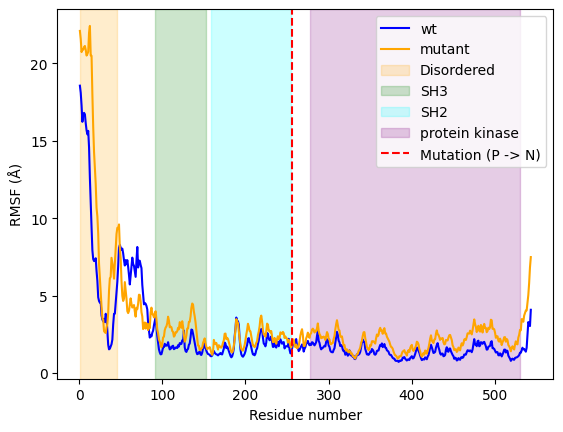

In [74]:
%matplotlib inline

# Plot de RMSF van het wildtype/de mutant
plt.plot(c_alphas_wildtype.resids,
         R_wildtype.results.rmsf,
         color = 'blue',
         label = 'wt'
         )
plt.plot(c_alphas_mutant.resids,
         R_mutant.results.rmsf,
         color = 'orange',
         label = 'mutant'
         )
plt.xlabel('Residue number')
plt.ylabel('RMSF (Å)')
plt.axvspan(1, 45, zorder=0, alpha=0.2, color='orange', label='Disordered')
plt.axvspan(91, 152, zorder=0, alpha=0.2, color='green', label='SH3')
plt.axvspan(158, 255, zorder=0, alpha=0.2, color='cyan', label='SH2')
plt.axvspan(277, 530, zorder=0, alpha=0.2, color='purple', label='protein kinase')

plt.axvline(
    x=256,
    color='red',
    linestyle='--',
    label='Mutation (P -> N)'
)

plt.legend()


In de plot hierboven zien we nu de RMSF van het wildtype en de mutant, gemeten in Angstrom (Å), een lengtemaat gelijk aan $10^{−10}$ meter. De oranje lijn geeft het RMSF aan van de mutant, over alle aminozuren in het eiwit. En de blauwe lijn geeft het wildtype aan. Het YES1 eiwit heeft 3 domeinen:

- SH3 (91-152) (groen)
- SH2 (158-255) (blauw)
- Protein kinase (277-530) (paars)

Daarnaast is er nog een 'disordered' domein, van locatie 1-45. Hier valt het op dat zowel het wildtype als de mutant een hoge RMSF hebben en lijkt de structuur niet erg stabiel te zijn maar juist erg beweeglijk. De mutatie is aangegeven met een rode stippellijn op locatie 256, net buiten domein SH2.

De RMSF lijkt voor het wildtype redelijk stabiel over de 3 hoofddomeinen, deze blijft tussen de ~2-2.5 Å. Voor de mutant lijkt de RMSF in deze domeinen hoger te liggen dan voor het wildtype en ook lijkt de variantie groter, hier ligt de range tussen de ~2-4.8. Het verschil lijkt aanwezig over de gehele domeinen en niet alleen in specifieke regio's, mogelijk betekent dit dat de algehele beweeglijkheid van de complete domeinen is toegenomen bij de mutant. Opvallend lijkt de vorm van de RMSF nog gelijk, hoewel de RMSF hoger is bij de mutant, volgt het wel dezelfde pieken en dalen als bij het wildtype.

Om makkelijk regio's te kunnen identificeren met hoge beweeglijkheid, kunnen we een b-factor (temperatuur factor) gebruiken. De b-factor kan worden toegevoegd aan een PDB en op deze manier kunnen regio's gekleurd worden aan de hand van hun beweeglijkheid.


In [7]:
def beta_factor(u, R, output):
    u.add_TopologyAttr('tempfactors')
    protein = u.select_atoms('protein')
    for residue, r_value in zip(protein.residues, R.results.rmsf):
        residue.atoms.tempfactors = r_value

    u.atoms.write(output)

_, R_wildtype, u_wildtype = calculate_RMSF("wildtype_protein.pdb", "wildtype_protein.xtc")
_, R_mutant, u_mutant = calculate_RMSF("mutant_protein.pdb", "mutant_protein.xtc")
beta_factor(u_wildtype, R_wildtype, "wildtype_rmsf.pdb")
beta_factor(u_wildtype, R_wildtype, "mutant_rmsf.pdb")

Met het python script `visualizeRMSF` kunnen mutant en wildtype worden bekeken en beweeglijke regio's worden geïdentificeerd. Hieronder zijn wildtype en mutant op elkaar ge-aligned en is de RMSF met kleuren aangegeven, waarbij blauw een lage RMSF is (lage beweeglijkheid), wit een 'middelmatige' RMSF en rood een hoge RMSF (hoge beweeglijkheid). Het valt op dat voor beide varianten dezelfde plekken een middel-tot hoge RMSF hebben, namelijk in de lange loop die langs het eiwit loopt. Vanaf ongeveer residu 1-30 eb 45-79 is de beweeglijkheid middelmatig tot hoog. De regio van 1-30 valt binnen het disordered 'domein', dus is een hoge RMSF te verwachten. 45-79 ligt niet binnen een domein. Alle gedeelten binnen de 3 daadwerkelijke domeinen (SH2, SH3, protein kinase) zijn blauw gekleurd en zijn dus best stabiel.

<img src="imgs/rmsf_wt_mutant.png" width="50%">

<img src="imgs/rmsf_mt_wildtype.gif" width="50%">

# Secundaire structuren

Nu gaan we de secundaire structuren van het wildtype en de mutant vergelijken. Eerst doen we dit op basis van de PDB, de PDB van het wildtype is gemaakt met: `gmx trjconv -s wildtype_protein.tpr -f ../wats-w/wildtype.xtc -pbc mol -o ../wildtype/wildtype_protein.pdb -dump 0`. De PDB van de mutant is op dezelfde manier gemaakt, maar dan met de tpr en xtc van de mutant. De PDB bestaat dus uit de eerste frame van de run. Vervolgens kunnen we deze PDB's omzetten in universe objecten en hieruit de secundaire structuren voorspellen. We selecteren hierbij residue 1-542, omdat het laatste residu geen peptidebinding aangaat, waardoor de COOH-groep blijft behouden. Deze worden dan onjuist genoteerd als CO1 en CO2, wat niet goed werkt met MDAnalysis.

In [60]:
# bepaal secundaire structuur op basis van de eerste frame
def secondaryPDB(pdb):
    u = mda.Universe(pdb).select_atoms('resid 1-542')
    secondary_structure = ''.join(DSSP(u).run().results.dssp[0]) + '-'
    return secondary_structure

secondary_PDB_structure_mutant = secondaryPDB("mutant_protein.pdb")
secondary_PDB_structure_wildtype = secondaryPDB("wildtype_protein.pdb")

print("____________Secondary Structure Wildtype PDB__________")
print(secondary_PDB_structure_wildtype)
print(f"N. of Es:{secondary_PDB_structure_wildtype.count("E")}")
print(f"N. of Hs:{secondary_PDB_structure_wildtype.count("H")}")
print(f"N. of -s:{secondary_PDB_structure_wildtype.count("-")}")


print("____________Secondary Structure Mutant PDB__________")
print(secondary_PDB_structure_mutant)
print(f"N. of Es:{secondary_PDB_structure_mutant.count("E")}")
print(f"N. of Hs:{secondary_PDB_structure_mutant.count("H")}")
print(f"N. of -s:{secondary_PDB_structure_mutant.count("-")}")

____________Secondary Structure Wildtype PDB__________
------------------------------------E----------------------------------------------------------EEE---E------E--E----EEEE-E-----EEEEEE----EEEEEEHHHEEE---HHH---E-------HHHHHHH-------EEEEEE-------EEEEEEEEE---EEEEEEEEEEE-----EE-----EE--HHHHHHHH----E-E-----EE----------------E--HHHEEE-EE-EE----EEEEEEE---EEEEEEE-------HHHHHHHHHHHHH-----E--E-EEE-----EEEE-----EEHHHHHHH--HHH--HHHHHHHHHHHHHHHHHHHHH-EE-----HHHEEE-HHH-EEE------EE-E--EEE------E-HHH--HHHHHH-EE-HHHHHHHHHHHHHHHH-----------HHHHHHHHH------------HHHHHHHHH-----HHH---HHHHHHHHH----------------
N. of Es:112
N. of Hs:129
N. of Hs:302
____________Secondary Structure Mutant PDB__________
-----------------------------------------------------------------------------------------------EEE---E------E--E----EEEE-E-----EEEEEE-----EEEEEHHHEEE---HHH---E-------HHHHHHH-------EEEEEE-------EEEEEEEEE---EEEEEEEEEEE-----EE-E--EEE--HHHHHHHH------------EE----------------E--HHHEEE-EE-EE---EEEEEEEE---EEEEEEEE--

Hierboven zie je de secundaire structuren van wildtype/mutant, op basis van de PDB (eerste frame van de run). Er zijn 3 verschillende soorten tekens te zien, `E` (sheet), `H` (helix) en `-` (loop). Er zijn gelijk al een aantal verschillen te zien tussen wildtype en mutant, zo lijken een aantal E's bij het wildtype niet aanwezig te zijn bij de mutant, en andersom. Hetzelfde geldt voor de H's. Het totaal aan E's en H's lijkt dan ook te verschillen onderling. 112 E's bij wildtype en 109 bij mutant en 129 H's bij wildtype en 126 bij mutant. Het aantal loops lijkt toegenomen te zijn bij de mutant ten opzichte van het wildtype.

Gezien dit alleen laat zien hoe de secundaire structuren eruit zien tijdens de eerste frame, is het ook goed om verder te kijken naar de rest van de frames. Dat doen wij hieronder. Voor elke `residue` (aminozuur) wordt gekeken naar wat de gemiddelde secundaire structuur hiervan is binnen het eiwit. Dat wil zeggen dat als van alle frames, het residu het vaakste onderdeel was van een helixstructuur, dat het dan een `H` krijgt toegewezen.

In [61]:
# bepaal gemiddelde secundaire structuur van alle residues
def secondaryTPR(tpr, xtc):
    u = mda.Universe(tpr, xtc).select_atoms('resid 1-542')
    long_run = DSSP(u).run()
    mean_secondary_structure = translate(long_run.results.dssp_ndarray.mean(axis=0))
    structure = ''.join(mean_secondary_structure)
    print(structure)
    print(f"N. of Es:{structure.count("E")}")
    print(f"N. of Hs:{structure.count("H")}")
    print(f"N. of -s:{structure.count("-")}")

print("____________Secondary Structure Wildtype PDB__________")
secondaryTPR("wildtype_protein.tpr", "wildtype_protein.xtc")
print("____________Secondary Structure Mutant PDB__________")
secondaryTPR("mutant_protein.tpr", "mutant_protein.xtc")

____________Secondary Structure Wildtype PDB__________
------------------------------------E---------------------------------------------------------EEEE---E------E--E----EEEE-E-----EEEEEE-----EEEEEHHHEEE---HHH---E-----HHHHHHHH---------EEEEE-------EEEEEEEEE---EEEEEEEEEEE-----EE-----EE--HHHHHHHH-------------E----------------E--HHHEEE-EE-EE---EEEEEEEE---EEEEEEEE------HHHH-HHHHHH-------E--E-EEE-----EEEE-----EEHHHHHH--HHHH--HHHHHHHHHHHHHHHHHHHH--EE-----HHHEEE-HHH-EEE------EE-----EE------E------HHHHH--EE-HHHHHHHHHHHHHHHH-----------HHHHHHHHH------------HHHHHHHHHH----------HHHHHHHH----------------
N. of Es:108
N. of Hs:119
N. of Hs:315
____________Secondary Structure Mutant PDB__________
---------------------------------------------------------------HHH-----------------------------EEE---E------E--E----EEEE-E-----EEEEEE-----EEEEEHHHEEE---HHH---E-------HHHHHH---------EEEEE-------EEEEEEEEE---EEEEEEEEEEE-----EE-----EE--HHHHHHHH-------------E----------------E--HHHEEE-EE-EE---EEEEEEEE---EEEEEEEE---

Ook hier zijn er weer verschillen te zien in aantallen en locaties van `E`, `H` en `-`. Al lijken deze niet zo extreem groot, als je nagaat hoeveel frames er zijn en dat er in de aantallen slechts een klein verschil zit. Toch kunnen deze kleine verschillen een grote impact hebben op de ruimtelijke structuur en stabiliteit van het eiwit.

# Eindconclusie wildtype vs variant


# Bronnen
- MD Analysis User Guide. (z.d.). Calculating the root mean square fluctuation over a trajectory. https://userguide.mdanalysis.org/stable/examples/analysis/alignment_and_rms/rmsf.html
- Zhu, Z. (2020, 26 april). Introduction to Gromacs. EigenBlog. https://naturegeorge.github.io/eigenblog/posts/gmx/
- gmx pdb2gmx — GROMACS 5.1 documentation. (z.d.). https://manual.gromacs.org/documentation/5.1/onlinehelp/gmx-pdb2gmx.html
- Kook, E., Chun, K., & Kim, D. (2024). Emerging Roles of YES1 in Cancer: The Putative Target in Drug Resistance. _International Journal Of Molecular Sciences_, _25_(3), 1450. https://doi.org/10.3390/ijms25031450
- Embl-Ebi. (z.d.). _pLDDT: Understanding local confidence | AlphaFold_. https://www.ebi.ac.uk/training/online/courses/alphafold/inputs-and-outputs/evaluating-alphafolds-predicted-structures-using-confidence-scores/plddt-understanding-local-confidence/
- Zhou, H., Sun, D., Tao, J., Xu, M., Zhang, X., & Hou, H. (2023). Role of YES1 signaling in tumor therapy resistance. Cancer Innovation, 2(3), 210–218. https://doi.org/10.1002/cai2.51
- UniProt. (z.d.). https://www.uniprot.org/uniprotkb/P07947/entry

***

&copy; 2025 - Yamila Timmer, Ivar Lottman